# Deep Pensieve™ Re-Animation

## GPU Selection 

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
 
# The GPU id to use, usually either "0" or "1";
os.environ["CUDA_VISIBLE_DEVICES"]="1";

## Imports 

In [2]:
import time
import json
import random
import numpy as np
import tensorflow as tf

from libs import utils, gif
from libs.group_norm import GroupNormalization
from libs.variance_pooling import GlobalVariancePooling2D

from keras.models import Model, load_model, model_from_json
from keras.layers import Input, Flatten, Reshape, Add, Multiply, Activation, Lambda
from keras.layers import Dense, Conv2D, DepthwiseConv2D, SeparableConv2D
from keras.layers import MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D, UpSampling2D
from keras.callbacks import LambdaCallback
from keras.utils import multi_gpu_model

from keras import optimizers
from keras import backend as K

from keras_contrib.losses import DSSIMObjective
from keras_contrib.layers.convolutional.subpixelupscaling import SubPixelUpscaling

Using TensorFlow backend.


## Load Images

In [3]:
DIRECTORY = 'alp'
SIZE = 128
SCALE_FACTOR = 2

In [4]:
CHANNELS = 3

FEATURES = SIZE*SIZE*CHANNELS
FEATURES_2X = SCALE_FACTOR*SIZE*SCALE_FACTOR*SIZE*CHANNELS

MODEL_NAME = DIRECTORY+'-'+str(SIZE)+'-'+str(time.time())

In [5]:
# load images
imgs, xs, ys  = utils.load_images(directory="imgs/"+DIRECTORY,rx=SIZE,ry=SIZE)
imgs_2x, xs_2x, ys_2x = utils.load_images(directory="imgs/"+DIRECTORY,rx=SCALE_FACTOR*SIZE,ry=SCALE_FACTOR*SIZE)

# normalize pixels
IMGS = imgs/127.5 - 1
IMGS_C = IMGS ; IMGS_F = np.reshape(IMGS_C,(-1,FEATURES))

# normalize 2x pixels
IMGS_2X = imgs_2x/127.5 - 1
IMGS_2X_C = IMGS_2X ; IMGS_2X_F = np.reshape(IMGS_2X_C,(-1,FEATURES_2X))

SAMPLES =  np.random.permutation(IMGS_F)[:4]
SAMPLES_2X =  np.random.permutation(IMGS_2X_F)[:4]

TOTAL_BATCH = IMGS.shape[0]

# print shapes
print("MODEL: ",MODEL_NAME)
print("IMGS: ",IMGS_C.shape,IMGS_2X_C.shape)
print("FLAT: ",IMGS_F.shape,IMGS_2X_F.shape)
print("SAMPLES: ",SAMPLES.shape,SAMPLES_2X.shape)

Loading images:	202
Loading images:	202
MODEL:  alp-128-1554550579.7429218
IMGS:  (202, 128, 128, 3) (202, 256, 256, 3)
FLAT:  (202, 49152) (202, 196608)
SAMPLES:  (4, 49152) (4, 196608)


## Load Model

In [9]:
MODEL_NAME = 'alp-128-1554340166.732095'

LATENT_DIM = 512

print('loading encoder ...', MODEL_NAME)
ENCODER = load_model(MODEL_NAME+'-encoder-model.h5')

print('loading decoder ...')
DECODER = load_model(MODEL_NAME+'-generator-model.h5', custom_objects={'GlobalVariancePooling2D':GlobalVariancePooling2D,'SubPixelUpscaling':SubPixelUpscaling})

print('loading supersizer ...')
SUPERSIZER = load_model(MODEL_NAME+'-supersizer-model.h5',custom_objects={'GlobalVariancePooling2D':GlobalVariancePooling2D,'SubPixelUpscaling':SubPixelUpscaling})

print("done")

loading encoder ... alp-128-1554340166.732095
loading decoder ...
loading supersizer ...
done


## Re-Animate 

In [10]:
def random_latents(n_imgs=3,steps=30):
    rimgs = np.random.permutation(IMGS_F)[:n_imgs]
    rimgs = np.append(rimgs, [rimgs[0]],axis=0)
    latent_animation(rimgs,steps,filename=str(time.time()))

def latent_animation(imgs=None,steps=None,filename="latent-animation"):
    animate(generate(get_latents(imgs,steps),filename),filename)
    
def get_latents(imgs,steps):
    # get latent encodings for images
    print('encoding latent vectors ...')
    latents = []
    
    for index,img in enumerate(imgs):
        img = np.reshape(img,(-1,FEATURES))
        latent = ENCODER.predict_on_batch(img)
        latents.append(latent)
    
    # calculate latent path
    print('calculating latent path ...')
    latent_path = []
    for i in range(len(latents)-1):
        # get latent vectors
        l1 = latents[i] ; l2 = latents[i+1]

        # calculate latent distance
        image_distance = l2 - l1

        # create the latent path
        for j in range(steps):
            latent_path.append(l1 + j*image_distance/steps)
        latent_path.append(l2)
    
    return latent_path
       
    
def generate(latent_path,filename=None):
     # reconstruct images along the path
    latent_path = np.reshape(latent_path,(-1,LATENT_DIM))
    
    print('decoding ...')
    recons = DECODER.predict_on_batch(latent_path)
    
    if(filename != None):
        print('saving decoder gif')
        build_gif(np.asarray(recons),SIZE,filename)
    
    return recons
    
def animate(recons,filename=None):
    print('supersizing ...')
    chunks = SUPERSIZER.predict_on_batch(recons[:10])
    
    for i in range(10,len(recons),10):
        s2 = SUPERSIZER.predict_on_batch(recons[i:i+10])
        chunks = np.concatenate([chunks,s2])
    
    print('saving supersizer gif')
    build_gif(chunks,SIZE*SCALE_FACTOR,filename+"-"+str(SCALE_FACTOR)+"x")
   
    print(filename)
#     return chunks
    
def build_gif(recons,size,filename='latent-animation'):
    final = np.clip((127.5*(recons+1)),0,255)
    gif.build_gif([utils.montage([r]).astype(np.uint8) for r in final], saveto=filename+".gif",dpi=72)

## Grid 

In [ ]:
SCALE_FACTOR=1
GRID = 4
N_IMGS = 3
STEPS = 35

for j in range(5):
    grid=[]
    for i in range(GRID):
        imgs = np.random.permutation(IMGS_F)[:N_IMGS]
        imgs = np.append(imgs, [imgs[0]],axis=0)
        latent_path = get_latents(imgs,STEPS)
        recons = generate(latent_path)
        final = np.clip((127.5*(recons+1)).reshape((-1,SIZE*SCALE_FACTOR,SIZE*SCALE_FACTOR,CHANNELS)),0,255)
        grid.append(final)
        
    rs = []
    for img in grid:
        rs.append([frame for frame in img])
    rs = np.moveaxis(grid,1,0)
    print('saving ...')
    filename = str(time.time())+".gif"
    gif.build_gif([utils.montage(r).astype(np.uint8) for r in rs], saveto=filename,dpi=72)

    print('done ... ',filename)

## Sequence 

0
encoding latent vectors ...
calculating latent path ...
decoding ...
saving decoder gif
supersizing ...
saving supersizer gif
1554550737.281835-000
1
encoding latent vectors ...
calculating latent path ...
decoding ...
saving decoder gif
supersizing ...
saving supersizer gif
1554550737.281835-001
2
encoding latent vectors ...
calculating latent path ...
decoding ...
saving decoder gif
supersizing ...
saving supersizer gif
1554550737.281835-002
3
encoding latent vectors ...
calculating latent path ...
decoding ...
saving decoder gif
supersizing ...
saving supersizer gif
1554550737.281835-003
4
encoding latent vectors ...
calculating latent path ...
decoding ...
saving decoder gif
supersizing ...
saving supersizer gif
1554550737.281835-004
5
encoding latent vectors ...
calculating latent path ...
decoding ...
saving decoder gif
supersizing ...
saving supersizer gif
1554550737.281835-005
6
encoding latent vectors ...
calculating latent path ...
decoding ...
saving decoder gif
supersizin

saving decoder gif
supersizing ...
saving supersizer gif
1554550737.281835-054
55
encoding latent vectors ...
calculating latent path ...
decoding ...
saving decoder gif
supersizing ...
saving supersizer gif
1554550737.281835-055
56
encoding latent vectors ...
calculating latent path ...
decoding ...
saving decoder gif
supersizing ...
saving supersizer gif
1554550737.281835-056
57
encoding latent vectors ...
calculating latent path ...
decoding ...
saving decoder gif
supersizing ...
saving supersizer gif
1554550737.281835-057
58
encoding latent vectors ...
calculating latent path ...
decoding ...
saving decoder gif
supersizing ...
saving supersizer gif
1554550737.281835-058
59
encoding latent vectors ...
calculating latent path ...
decoding ...
saving decoder gif
supersizing ...
saving supersizer gif
1554550737.281835-059
60
encoding latent vectors ...
calculating latent path ...
decoding ...
saving decoder gif
supersizing ...
saving supersizer gif
1554550737.281835-060
61
encoding lat

KeyboardInterrupt: 

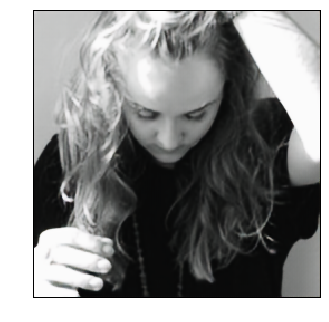

In [11]:
imgs =  np.random.permutation(IMGS_F)
t = str(time.time())
for i in range(TOTAL_BATCH):
    print(i)
    latent_animation([imgs[i],imgs[i+1]],100,filename=t+'-'+ ('%03d' % i))

## Reconstruction 

In [ ]:
def reconstruct(index=0):
    
    # input
    x = np.reshape(IMGS_F[index],(-1,FEATURES))
    z = ENCODER.predict_on_batch(x)
    
    # output
    img = DECODER.predict_on_batch(z)
    img_f = np.reshape(img,(-1,FEATURES))
    
    img_s = SUPERSIZER.predict_on_batch(img)
    img_sf = np.reshape(img_s,(-1,FEATURES*SCALE_FACTOR*SCALE_FACTOR))
    
    # reference
    ref = IMGS[index]/2 + .5
    ref_s = IMGS_2X[index]/2 + .5
    
    # denormalize
    img = np.reshape(img/2 + .5,(SIZE,SIZE,CHANNELS))
    img_s= np.reshape(img_s/2 + .5,(SCALE_FACTOR*SIZE,SCALE_FACTOR*SIZE,CHANNELS))
    
    # print scores
    print("PSNR: %.3f %.3f <> MS-SSIM: %.3f %.3f" % ((utils.psnr(ref,img)),
                                                     (utils.psnr(ref_s,img_s)),
                                           (utils.MultiScaleSSIM(np.reshape(ref,(1,SIZE,SIZE,CHANNELS)),
                                                                 np.reshape(img,(1,SIZE,SIZE,CHANNELS)),
                                                                 max_val=1.)),
                                            (utils.MultiScaleSSIM(np.reshape(ref_s,(1,SCALE_FACTOR*SIZE,SCALE_FACTOR*SIZE,CHANNELS)),
                                                                 np.reshape(img_s,(1,SCALE_FACTOR*SIZE,SCALE_FACTOR*SIZE,CHANNELS)),
                                                                 max_val=1.))
                                               ))
    
    # show images
    utils.showImagesHorizontally(images=[ref,img])
    utils.showImagesHorizontally(images=[ref_s,img_s])

In [ ]:
reconstruct(random.randint(0,TOTAL_BATCH-1))